Oluwatimileyin Obagbuwa 2134111<br>
Suraksha Motilal 2108903<br>
Byron Kruger 2090048<br>
Derrin Naidoo (2127039)

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import cv2
import random
from skimage.color import rgb2hsv
import math
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

from glob import glob
from skimage import img_as_float32
from natsort import natsorted
import imageio

# path_pairs = list(zip(
# natsorted(glob('/content/drive/MyDrive/CGV/Lab6Imgs/puzzle_corners_1024x768/images-1024x768/*.png')),
# natsorted(glob('/content/drive/MyDrive/CGV/Lab6Imgs/puzzle_corners_1024x768/masks-1024x768/*.png')),
# ))

#read in data
path_pairs = list(zip(
    natsorted(glob('puzzle_corners_1024x768/images-1024x768/*.png')),
    natsorted(glob('puzzle_corners_1024x768/masks-1024x768/*.png')),
))

imgs = np.array([img_as_float32(imageio.imread(ipath)) for ipath, _ in path_pairs])
msks = np.array([img_as_float32(imageio.imread(mpath)) for _, mpath in path_pairs])

Mounted at /content/drive


In [ ]:
print(imgs[0].shape)

(768, 1024, 3)


In [ ]:
#Resize images
scale = 0.25
imgs = np.array([cv2.resize(img, None, fx=scale, fy=scale) for img in imgs])
msks = np.array([cv2.resize(img, None, fx=scale, fy=scale)for img in msks])

In [ ]:
print(imgs[0].shape)

(192, 256, 3)


Train one GMM for the foreground and another for the background, then replace the normal class conditional
likelihood terms in Equation 2 with the relevant mixture models. Do not confuse the λ class prior in Equation
2 with the λk categorical weights inside the GMM. These are different quantities.
You should consider the following feature sets:
1. RGB pixel value
2. RGB+Difference of Gaussian
3. One other feature set from the previous labs that performed well.
Evaluate this new model using your validation dataset and explore different numbers of components in the two
mixtures and vary the other hyperparameters you have in your features. Once you have chosen the optimal
hyperparameters using your validation set, perform a final evaluation of your model using your test set.
In your report, present your results and compare this model with the previous models. How do they compare in
terms of training time, inference time, number of parameters, accuracy etc.?


Submission Note: You may use scipi.stats’s multivariate normal as well as general numpy
functions but you should implement your actual GMMs from scratch. You may even use Tensorflow/PyTorch
to parallelise your implementations, but the actual GMM mathematics cannot come from a library. You should definitely vectorise your code, note that for-loops in python will introduce a severe computational cost in this
model.


Grading Note: You should structure your code sensibly and reuse functions/classes where-ever possible. I suggest creating a GMM class which you can reuse when you need to build a separate background and foreground
models.

In [ ]:
# split the data in training and remaining dataset
training_imgs, imgs_rem, training_msks, msks_rem = train_test_split(imgs,msks, train_size=0.7, random_state = 42)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
validation_imgs, testing_imgs, validation_msks, testing_msks = train_test_split(imgs_rem,msks_rem, test_size=0.5, random_state = 42)

In [ ]:
def getMean(n_features):
  means = []
  for i in range(n_features):
    means.append(random.uniform(0,1))
  return np.array(means)

In [ ]:
def getCovMat(n):
  A = np.random.random(n)
  A = A * np.transpose(A)
  A = A + (100 * np.eye(n))
  return A

In [ ]:
def get_features(imgs, kernelSize1, kernelSize2):
  r,g,b = cv2.split(imgs[0])
  r2, g2, b2 = cv2.split((cv2.GaussianBlur(imgs[0],(kernelSize1,kernelSize1),0)) - (cv2.GaussianBlur(imgs[0],(kernelSize2,kernelSize2),0)))
  h,s,v = cv2.split(rgb2hsv(imgs[0]))

  for i in range(1,len(imgs)):
    red, green, blue = cv2.split(imgs[i])
    red2, green2, blue2 = cv2.split((cv2.GaussianBlur(imgs[i],(kernelSize1,kernelSize1),0)) - (cv2.GaussianBlur(imgs[i],(kernelSize2,kernelSize2),0)))
    h2,s2,v2 = cv2.split(rgb2hsv(imgs[i]))
    r = np.append(r, red)
    g = np.append(g, green)
    b = np.append(b, blue)
    r2 = np.append(r2, red2)
    g2 = np.append(g2, green2)
    b2 = np.append(b2, blue2)
    h = np.append(h, h2)
    s = np.append(s, s2)
    v = np.append(v, v2)
  
  return np.array([r.flatten(),g.flatten(),b.flatten(),(r+r2).flatten(), (g+g2).flatten(), (b+b2).flatten(), h.flatten(),s.flatten(),v.flatten()]).transpose()

In [ ]:
def get_features_rgb(imgs):
  r,g,b = cv2.split(imgs[0])

  for i in range(1,len(imgs)):
    red, green, blue = cv2.split(imgs[i])
    r = np.append(r, red)
    g = np.append(g, green)
    b = np.append(b, blue)
  
  
  return np.array([r.flatten(),g.flatten(),b.flatten()]).transpose()

In [ ]:
def get_features_hsv(imgs):
  
  h,s,v = cv2.split(rgb2hsv(imgs[0]))

  for i in range(1,len(imgs)):
   
    h2,s2,v2 = cv2.split(rgb2hsv(imgs[i]))
   
    h = np.append(h, h2)
    s = np.append(s, s2)
    v = np.append(v, v2)
  
  return np.array([h.flatten(),s.flatten(),v.flatten()]).transpose()

In [ ]:
def get_features_doG(imgs, kernelSize1, kernelSize2):
  
  r2, g2, b2 = cv2.split((cv2.GaussianBlur(imgs[0],(kernelSize1,kernelSize1),0)) - (cv2.GaussianBlur(imgs[0],(kernelSize2,kernelSize2),0)))
  

  for i in range(1,len(imgs)):
    
    red2, green2, blue2 = cv2.split((cv2.GaussianBlur(imgs[i],(kernelSize1,kernelSize1),0)) - (cv2.GaussianBlur(imgs[i],(kernelSize2,kernelSize2),0)))

    
    r2 = np.append(r2, red2)
    g2 = np.append(g2, green2)
    b2 = np.append(b2, blue2)
   
  
  return np.array([r2.flatten(), g2.flatten(), b2.flatten()]).transpose()

In [ ]:
def get_features_rgbdoG(imgs, kernelSize1, kernelSize2):
  r,g,b = cv2.split(imgs[0])
  r2, g2, b2 = cv2.split((cv2.GaussianBlur(imgs[0],(kernelSize1,kernelSize1),0)) - (cv2.GaussianBlur(imgs[0],(kernelSize2,kernelSize2),0)))
  

  for i in range(1,len(imgs)):
    red, green, blue = cv2.split(imgs[i])
    red2, green2, blue2 = cv2.split((cv2.GaussianBlur(imgs[i],(kernelSize1,kernelSize1),0)) - (cv2.GaussianBlur(imgs[i],(kernelSize2,kernelSize2),0)))

    r = np.append(r, red)
    g = np.append(g, green)
    b = np.append(b, blue)
    r2 = np.append(r2, red2)
    g2 = np.append(g2, green2)
    b2 = np.append(b2, blue2)
   
  
  return np.array([r.flatten(),g.flatten(),b.flatten(),r2.flatten(), g2.flatten(), b2.flatten()]).transpose()

In [ ]:
def split_features(masks, features):
  background = features[masks.reshape(-1)<0.5]
  foreground = features[masks.reshape(-1)>0.5]
  
  return np.array(background) , np.array(foreground)

In [ ]:
def GMM(n_clusters, side, epsilon, max_iters, min_iters, foreground, background):

  ##########################  GET FEATURES FOR TRAINING###################################
  
  if side == "foreground":
    features = foreground
  elif side == "background":
    features = background
  else:
    print("invalid side")
    return
  #############################################################################################
 
  ################ INITIALISE CLUSTERS PARAMETERS ###############################
  

  mean = []     # mean vector for each cluster
  cov_mat = []  #covariance matrix for each cluster
  delta = []  #deltas

  for i in range(n_clusters):
    cov_mat.append(getCovMat(len(features.transpose())))
    mean.append(getMean(len(features.transpose())))
    delta.append(random.uniform(0,1))
  ###############################################################################

  m_c = np.zeros((n_clusters,), dtype=float)  # array of total responsibility for each cluster

  has_converged = False

  # initialise log likelihood for convergence
  log_likelihood = 0

  n_iters = 0
  
  while has_converged == False:

    res = []   #list of responsibility matrices
   
    ######################## EXPECTATION STEP: EACH CLUSTER TO CALCULATE THE RESPONSIBILITIES#############################
    for i in range(n_clusters):
      res.append((delta[i] * multivariate_normal(mean[i],cov_mat[i]).pdf(features)))

    # USED FOR CHECKING FOR CONVERGENCE
    res = np.array(res)
    log_likelihood_new=np.sum(np.log(np.sum(res.transpose(), axis=1)))
    #print(log_likelihood_new)
    
    res = res/(res.sum(axis = 0, keepdims = 1))

    #################################################################################################################

    ################################# MAXIMISATION STEP ###########################################################
    #print("delta: ", delta)
    #print("res shape", np.array(res).shape)
    for i in range(n_clusters):  #CALCULATE TOTAL RESPONSIBILITIES
      m_c[i] = np.sum(res[i])  # total responsibility for cluster i

    #print("m_c", m_c)
    for i in range(n_clusters): 
      delta[i] = m_c[i]/np.sum(m_c)   #update delta
      mean[i] = (1/m_c[i]) * np.sum((features * res[i][:, None]) , axis=0)  #update mean
      #print("mean" + str(i), mean[i])

      ########################## COVARIANCE MATRIX##########################
      
      cov_mat[i] = (res.transpose()[:,i]*(features - mean[i]).transpose() @ (features - mean[i])) / m_c[i]
      cov_mat[i] = cov_mat[i] + (0.001 * np.eye(len(features.transpose())))
      
      ##########################################################################

    ###################################################################################################################

    # CHECK FOR CONVERGENCE
    # print(n_iters)
    if n_iters == max_iters or abs(log_likelihood_new - log_likelihood) <= epsilon:
      has_converged = True
    n_iters += 1
    log_likelihood = log_likelihood_new
      

  return delta, mean, cov_mat, n_iters

In [ ]:
def predict(features, delta, mean, cov, n_clusters):
        
      prob=0 
      for i in range(n_clusters):
          prob += delta[i]*multivariate_normal(mean = mean[i], cov= cov[i]).pdf(features)
      return prob

In [ ]:
def get_predicted_masks(features, delta_background, mean_background, cov_background, delta_foreground, mean_foreground, cov_foreground, n_clusters, prior, shape):
  back_prob = predict(features, delta_back, mean_back, cov_back, 2)
  fore_prob = predict(features, delta_fore, mean_fore, cov_fore, 2)

  total_prob = (prior * fore_prob) / ((prior * fore_prob) + ((1 - prior) * back_prob))

  predictions = (total_prob>0.5).astype(np.float32)

  #reshaping predictions back to original image shape
  return predictions.reshape(shape)

In [ ]:
def plot_predictions(test_msks, pred_msks): 
    total_slots = pred_msks.shape[0]
    half = math.ceil(total_slots/2)
    n_rows = half
    n_cols = 2

    plt.figure(figsize=(15,15))
    index = 1
    for i in range(1,pred_msks.shape[0]+1,2):
      plt.subplot(n_rows, n_cols, i)
      plt.imshow(pred_msks[index], cmap="gray")
      plt.title("Predicted Image_" + str(index))
      plt.xticks([], [])
      plt.yticks([], [])
      plt.xlabel("Accuracy: " + str(accuracy_score((np.asarray(pred_msks[index]).astype(np.uint8)).flatten(), (np.asarray(test_msks[index]).astype(np.uint8)).flatten())))
      
      plt.subplot(n_rows, n_cols, i+1)
      plt.imshow(test_msks[index], cmap="gray")
      plt.title("Ground Truth Image_" + str(index))
      plt.xticks([], [])
      plt.yticks([], [])
      plt.axis('off')
      index += 1
    plt.show()


In [ ]:
 ##########################  DEFINE FEATURES FOR TRAINING ###################################
# total_features = get_features(training_imgs,15,11)
total_features = get_features(training_imgs, 11, 9)
background, foreground = split_features(training_msks, total_features)

#Initial Training With rgb,(rgb+doG),hsv combination

In [ ]:
n_iters_fg = 0
n_iters_bg = 0
start = time()
delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 2, side="background", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
delta_fore, mean_fore, cov_fore, n_iters_fg= GMM(n_clusters = 2, side="foreground", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
print("Total Training Time: ", time() - start)
print("Number of iterations for background GMM: ", n_iters_bg)
print("Number of iterations for foreground GMM: ", n_iters_fg)

Total Training Time:  38.29132151603699
Number of iterations for background GMM:  24
Number of iterations for foreground GMM:  31


In [ ]:
################### GET FEATURES FOR TESTING ##########################################
total_features_test = get_features(testing_imgs, 11, 9)

In [ ]:
########################## GET PREDICTED MASKS ###########################################
pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 2, prior = 0.4, shape = testing_msks.shape)

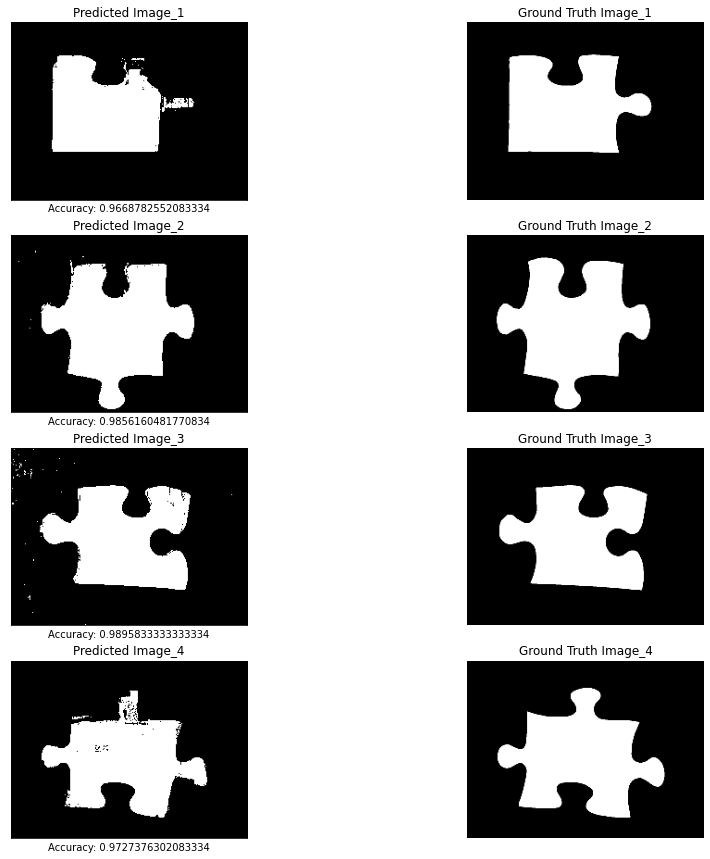

Total accuracy:  0.9610850016276041


In [ ]:
plot_predictions(testing_msks, pred_msks)
pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 2, prior = 0.4, shape = testing_msks.shape)
conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), testing_msks.flatten().astype(np.uint8))
accuracy = (conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
print("Total accuracy: ", accuracy)

##SEARCH FOR BEST HYPERPARAMETERS


#RGB

2 clusters (RGB)

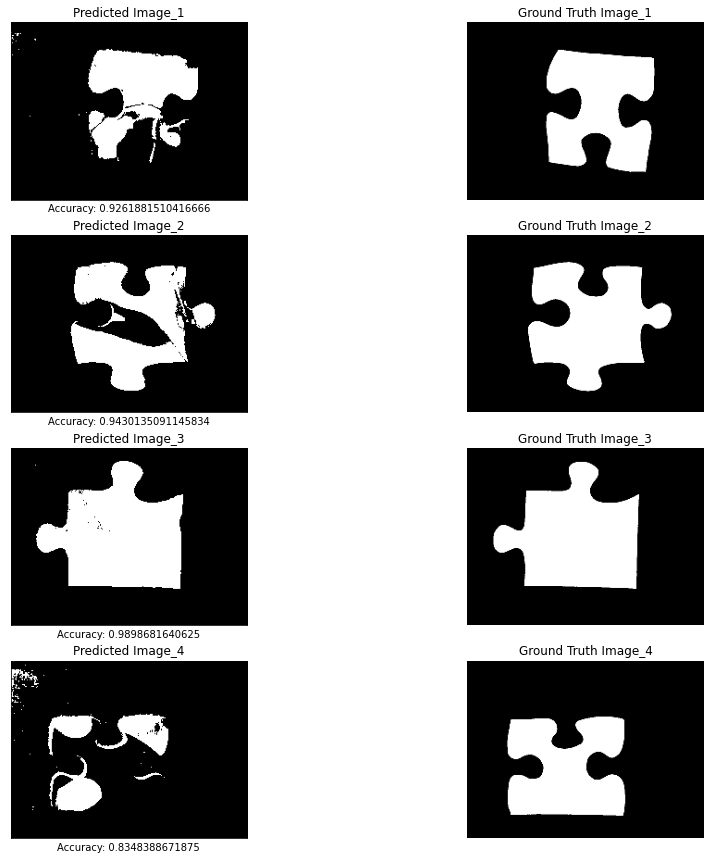

Average Training Time:  7.916523138682048
Average Total Accuracy after 3 runs: 0.9295935252356151


In [ ]:
features = get_features_rgb(training_imgs)
background, foreground = split_features(training_msks, features)

total_features_test = get_features_rgb(validation_imgs)
best_pred = np.array([])
accuracy = 0
max_acc = 0
n_runs = 3
start = time()
for i in range(n_runs):
  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 2, side="background", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 2, side="foreground", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 2, prior = 0.4, shape = validation_msks.shape)
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), validation_msks.flatten().astype(np.uint8))
  
  acc = (conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  accuracy += acc
  if acc > max_acc:
    best_pred = pred_msks
    max_acc = acc

end = time()
plot_predictions(validation_msks, best_pred)
print("Average Training Time: ", (end - start)/n_runs)
# print("Number of iterations for background GMM: ", n_iters_bg)
# print("Number of iterations for foreground GMM: ", n_iters_fg)

print('Average Total Accuracy after ' + str(n_runs)+ ' runs:',accuracy/n_runs)

6-fold validation for 2 clusters (RGB)

In [ ]:
# split imgs into 6 equal arrays (folds)
six_foldImgs=(np.array(np.split(imgs,6)))
six_foldMsk=(np.array(np.split(msks,6)))

# initialise accuracy
accuracy=0
start = time()
# loop through folds
# each fold has the opportunity to be a test set with the remaining folds representing the 
# training sets
for fold in range(six_foldImgs.shape[0]):
  print('Fold: ',str(fold))

  # compile the testing set= 1 fold
  testing_features=six_foldImgs[fold]
  testing_msks=six_foldMsk[fold]
  training_features=[]
  training_masks=[]

  # compile the training set which is equal to 5 folds
  for k in range(six_foldImgs.shape[0]):
    if (k!=fold):
      training_features.append(six_foldImgs[k])
      training_masks.append(six_foldMsk[k])
  training_features=np.array(training_features)
  training_masks=np.array(training_masks)
  
  training_features=training_features.reshape(40,training_features.shape[2], training_features.shape[3],3)
  training_masks=training_masks.reshape(40,training_masks.shape[2], training_masks.shape[3])



    ##########################  DEFINE FEATURES FOR TRAINING ###################################
  total_features = get_features_rgb(training_features)
  background, foreground = split_features(training_masks, total_features)

  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 2, side="background", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 2, side="foreground", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)


  ################### GET FEATURES FOR TESTING ##########################################
  total_features_test = get_features_rgb(testing_features)

  ########################## GET PREDICTED MASKS ###########################################
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 2, prior = 0.4, shape = testing_msks.shape)

  # generate confusion matrix to determine accuracy
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), testing_msks.flatten().astype(np.uint8))
  new_accuracy=(conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  print('Accuracy for fold',str(fold),":",new_accuracy)

  accuracy+=new_accuracy

end = time()
print("Total Training Time: ", (end - start))
# accuracy is mean of all the runs per fold as test set i.e. mean of 6 runs
print('Final accuracy',accuracy/6)

Fold:  0
Accuracy for fold 0 : 0.9173736572265625
Fold:  1
Accuracy for fold 1 : 0.948760986328125
Fold:  2
Accuracy for fold 2 : 0.9547551472981771
Fold:  3
Accuracy for fold 3 : 0.9049046834309896
Fold:  4
Accuracy for fold 4 : 0.9552968343098959
Fold:  5
Accuracy for fold 5 : 0.9398269653320312
Total Training Time:  37.542569160461426
Final accuracy 0.9368197123209635


3 clusters (RGB)

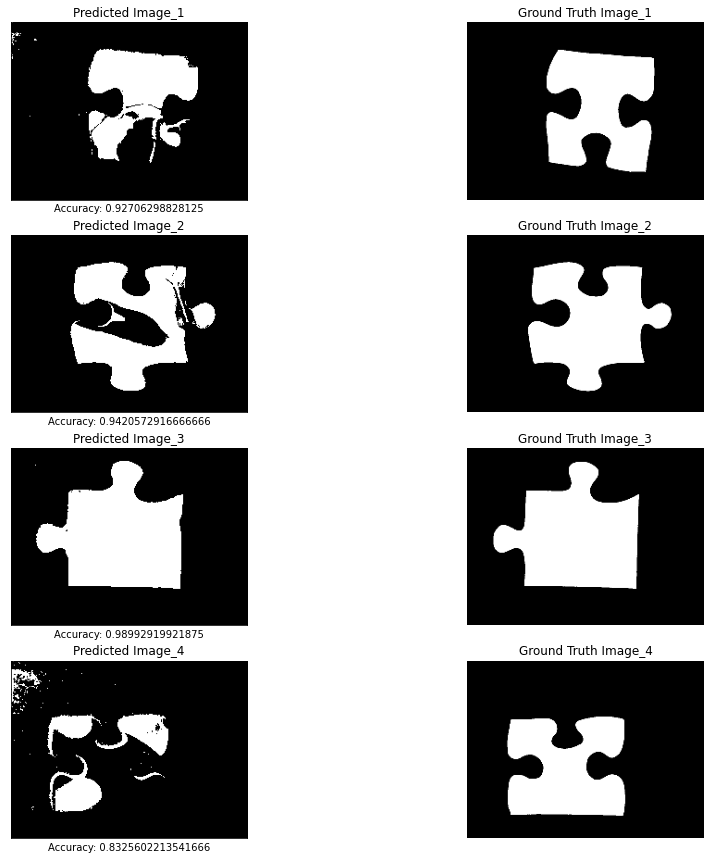

Average Training Time:  15.431363264719645
Average Total Accuracy after 3 runs: 0.9256301153273809


In [ ]:
features = get_features_rgb(training_imgs)
background, foreground = split_features(training_msks, features)

total_features_test = get_features_rgb(validation_imgs)
best_pred = np.array([])
accuracy = 0
max_acc = 0
n_runs = 3
start = time()
for i in range(n_runs):
  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 3, side="background", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 3, side="foreground", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 3, prior = 0.4, shape = validation_msks.shape)
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), validation_msks.flatten().astype(np.uint8))
  
  acc = (conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  accuracy += acc
  if acc > max_acc:
    best_pred = pred_msks
    max_acc = acc

end = time()
plot_predictions(validation_msks, best_pred)
print("Average Training Time: ", (end - start)/n_runs)
# print("Number of iterations for background GMM: ", n_iters_bg)
# print("Number of iterations for foreground GMM: ", n_iters_fg)

print('Average Total Accuracy after ' + str(n_runs)+ ' runs:',accuracy/n_runs)

6-fold validation fo 3 clusters (RGB)

In [ ]:
# split imgs into 6 equal arrays (folds)
six_foldImgs=(np.array(np.split(imgs,6)))
six_foldMsk=(np.array(np.split(msks,6)))

# initialise accuracy
accuracy=0
start = time()
# loop through folds
# each fold has the opportunity to be a test set with the remaining folds representing the 
# training sets
for fold in range(six_foldImgs.shape[0]):
  print('Fold: ',str(fold))

  # compile the testing set= 1 fold
  testing_features=six_foldImgs[fold]
  testing_msks=six_foldMsk[fold]
  training_features=[]
  training_masks=[]

  # compile the training set which is equal to 5 folds
  for k in range(six_foldImgs.shape[0]):
    if (k!=fold):
      training_features.append(six_foldImgs[k])
      training_masks.append(six_foldMsk[k])
  training_features=np.array(training_features)
  training_masks=np.array(training_masks)
  
  training_features=training_features.reshape(40,training_features.shape[2], training_features.shape[3],3)
  training_masks=training_masks.reshape(40,training_masks.shape[2], training_masks.shape[3])



    ##########################  DEFINE FEATURES FOR TRAINING ###################################
  total_features = get_features_rgb(training_features)
  background, foreground = split_features(training_masks, total_features)

  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 3, side="background", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 3, side="foreground", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)


  ################### GET FEATURES FOR TESTING ##########################################
  total_features_test = get_features_rgb(testing_features)

  ########################## GET PREDICTED MASKS ###########################################
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 3, prior = 0.4, shape = testing_msks.shape)

  # generate confusion matrix to determine accuracy
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), testing_msks.flatten().astype(np.uint8))
  new_accuracy=(conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  print('Accuracy for fold',str(fold),":",new_accuracy)

  accuracy+=new_accuracy

end = time()
print("Total Training Time: ", (end - start))
# accuracy is mean of all the runs per fold as test set i.e. mean of 6 runs
print('Final accuracy',accuracy/6)

Fold:  0
Accuracy for fold 0 : 0.9017969767252604
Fold:  1
Accuracy for fold 1 : 0.9466171264648438
Fold:  2
Accuracy for fold 2 : 0.9549153645833334
Fold:  3
Accuracy for fold 3 : 0.9041748046875
Fold:  4
Accuracy for fold 4 : 0.971710205078125
Fold:  5
Accuracy for fold 5 : 0.9249979654947916
Total Training Time:  66.04726052284241
Final accuracy 0.934035407172309


#HSV

2 clusters (HSV)

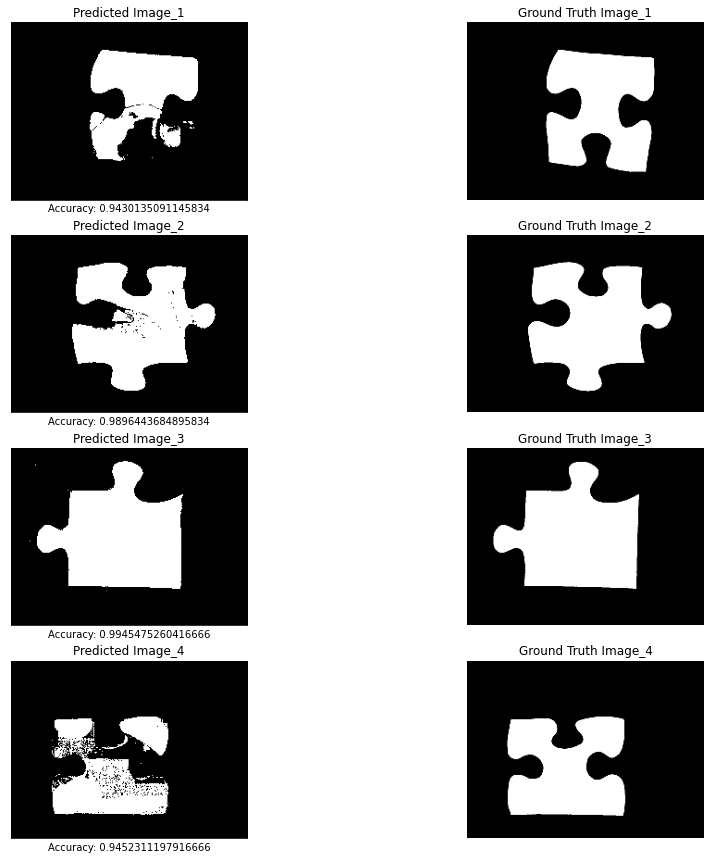

Average Training Time:  19.55446441968282
Average Total Accuracy after 3 runs: 0.9681725880456349


In [ ]:
features = get_features_hsv(training_imgs)
background, foreground = split_features(training_msks, features)

total_features_test = get_features_hsv(validation_imgs)
best_pred = np.array([])
accuracy = 0
max_acc = 0
n_runs = 3
start = time()
for i in range(n_runs):
  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 2, side="background", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 2, side="foreground", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 2, prior = 0.4, shape = validation_msks.shape)
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), validation_msks.flatten().astype(np.uint8))
  
  acc = (conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  accuracy += acc
  if acc > max_acc:
    best_pred = pred_msks
    max_acc = acc

end = time()

plot_predictions(validation_msks, best_pred)
print("Average Training Time: ", (end - start)/n_runs)
# print("Number of iterations for background GMM: ", n_iters_bg)
# print("Number of iterations for foreground GMM: ", n_iters_fg)
print('Average Total Accuracy after ' + str(n_runs)+ ' runs:',accuracy/n_runs)

6-fold validation for 2 clusters (HSV)

In [ ]:
# split imgs into 6 equal arrays (folds)
six_foldImgs=(np.array(np.split(imgs,6)))
six_foldMsk=(np.array(np.split(msks,6)))

# initialise accuracy
accuracy=0
start = time()
# loop through folds
# each fold has the opportunity to be a test set with the remaining folds representing the 
# training sets
for fold in range(six_foldImgs.shape[0]):
  print('Fold: ',str(fold))

  # compile the testing set= 1 fold
  testing_features=six_foldImgs[fold]
  testing_msks=six_foldMsk[fold]
  training_features=[]
  training_masks=[]

  # compile the training set which is equal to 5 folds
  for k in range(six_foldImgs.shape[0]):
    if (k!=fold):
      training_features.append(six_foldImgs[k])
      training_masks.append(six_foldMsk[k])
  training_features=np.array(training_features)
  training_masks=np.array(training_masks)
  
  training_features=training_features.reshape(40,training_features.shape[2], training_features.shape[3],3)
  training_masks=training_masks.reshape(40,training_masks.shape[2], training_masks.shape[3])



    ##########################  DEFINE FEATURES FOR TRAINING ###################################
  total_features = get_features_hsv(training_features)
  background, foreground = split_features(training_masks, total_features)

  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 2, side="background", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 2, side="foreground", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)


  ################### GET FEATURES FOR TESTING ##########################################
  total_features_test = get_features_hsv(testing_features)

  ########################## GET PREDICTED MASKS ###########################################
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 2, prior = 0.4, shape = testing_msks.shape)

  # generate confusion matrix to determine accuracy
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), testing_msks.flatten().astype(np.uint8))
  new_accuracy=(conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  print('Accuracy for fold',str(fold),":",new_accuracy)

  accuracy+=new_accuracy

end = time()
print("Total Training Time: ", (end - start))
# accuracy is mean of all the runs per fold as test set i.e. mean of 6 runs
print('Final accuracy',accuracy/6)

Fold:  0
Accuracy for fold 0 : 0.9504369099934896
Fold:  1
Accuracy for fold 1 : 0.96759033203125
Fold:  2
Accuracy for fold 2 : 0.9798609415690104
Fold:  3
Accuracy for fold 3 : 0.9363123575846354
Fold:  4
Accuracy for fold 4 : 0.9818929036458334
Fold:  5
Accuracy for fold 5 : 0.9532648722330729
Total Training Time:  188.4993016719818
Final accuracy 0.9615597195095487


3 clusters (HSV)

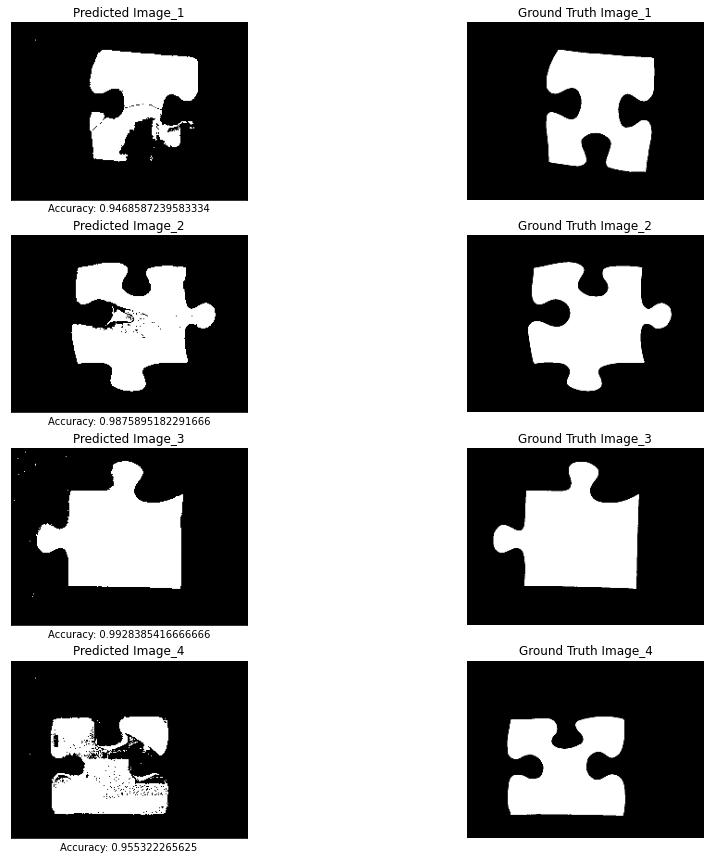

Average Training Time:  31.759031136830647
Average Total Accuracy after 3 runs: 0.9610527886284722


In [ ]:
features = get_features_hsv(training_imgs)
background, foreground = split_features(training_msks, features)

total_features_test = get_features_hsv(validation_imgs)
best_pred = np.array([])
accuracy = 0
max_acc = 0
n_runs = 3
start = time()
for i in range(n_runs):
  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters =3, side="background", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 3, side="foreground", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 3, prior = 0.4, shape = validation_msks.shape)
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), validation_msks.flatten().astype(np.uint8))
  
  acc = (conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  accuracy += acc
  if acc > max_acc:
    best_pred = pred_msks
    max_acc = acc

end = time()

plot_predictions(validation_msks, best_pred)
print("Average Training Time: ", (end - start)/n_runs)
# print("Number of iterations for background GMM: ", n_iters_bg)
# print("Number of iterations for foreground GMM: ", n_iters_fg)
print('Average Total Accuracy after ' + str(n_runs)+ ' runs:',accuracy/n_runs)

6-fold validation for 3 clusters (HSV)

In [ ]:
# split imgs into 6 equal arrays (folds)
six_foldImgs=(np.array(np.split(imgs,6)))
six_foldMsk=(np.array(np.split(msks,6)))

# initialise accuracy
accuracy=0
start = time()
# loop through folds
# each fold has the opportunity to be a test set with the remaining folds representing the 
# training sets
for fold in range(six_foldImgs.shape[0]):
  print('Fold: ',str(fold))

  # compile the testing set= 1 fold
  testing_features=six_foldImgs[fold]
  testing_msks=six_foldMsk[fold]
  training_features=[]
  training_masks=[]

  # compile the training set which is equal to 5 folds
  for k in range(six_foldImgs.shape[0]):
    if (k!=fold):
      training_features.append(six_foldImgs[k])
      training_masks.append(six_foldMsk[k])
  training_features=np.array(training_features)
  training_masks=np.array(training_masks)
  
  training_features=training_features.reshape(40,training_features.shape[2], training_features.shape[3],3)
  training_masks=training_masks.reshape(40,training_masks.shape[2], training_masks.shape[3])



    ##########################  DEFINE FEATURES FOR TRAINING ###################################
  total_features = get_features_hsv(training_features)
  background, foreground = split_features(training_masks, total_features)

  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 3, side="background", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 3, side="foreground", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)


  ################### GET FEATURES FOR TESTING ##########################################
  total_features_test = get_features_hsv(testing_features)

  ########################## GET PREDICTED MASKS ###########################################
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 3, prior = 0.4, shape = testing_msks.shape)

  # generate confusion matrix to determine accuracy
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), testing_msks.flatten().astype(np.uint8))
  new_accuracy=(conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  print('Accuracy for fold',str(fold),":",new_accuracy)

  accuracy+=new_accuracy

end = time()
print("Total Training Time: ", (end - start))
# accuracy is mean of all the runs per fold as test set i.e. mean of 6 runs
print('Final accuracy',accuracy/6)

Fold:  0
Accuracy for fold 0 : 0.9489186604817709
Fold:  1
Accuracy for fold 1 : 0.9649378458658854
Fold:  2
Accuracy for fold 2 : 0.9695281982421875
Fold:  3
Accuracy for fold 3 : 0.9353713989257812
Fold:  4
Accuracy for fold 4 : 0.9534200032552084
Fold:  5
Accuracy for fold 5 : 0.9637196858723959
Total Training Time:  290.78439259529114
Final accuracy 0.9559826321072048


#RGB + doG

GAUSSIAN DIFFERENCE OF 10

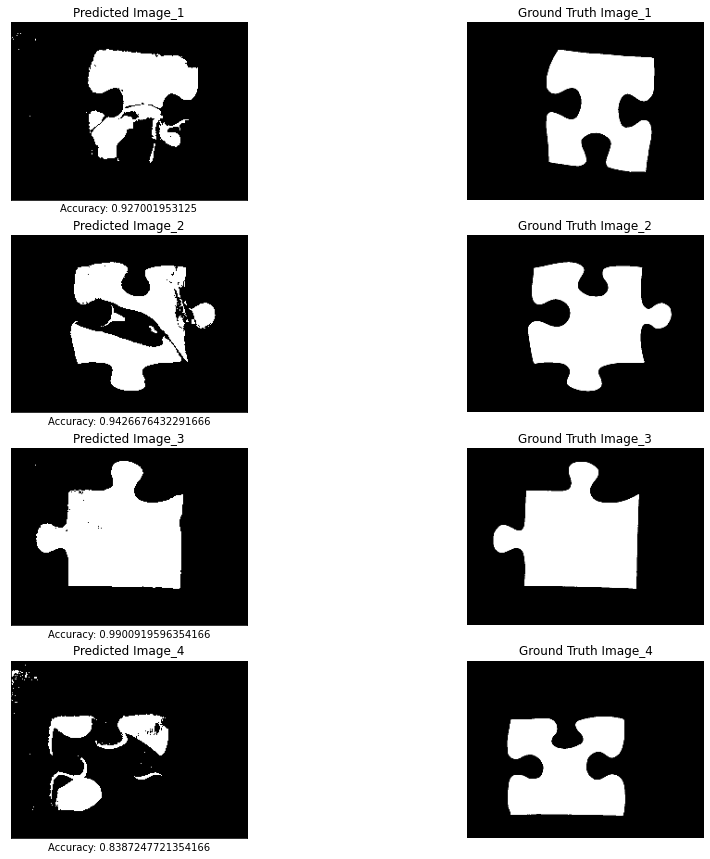

Average Training Time:  3.494441350301107
Average Total Accuracy after 3 runs: 0.9315737769717262


In [ ]:
features = get_features_rgbdoG(training_imgs, 49, 39)
background, foreground = split_features(training_msks, features)

total_features_test = get_features_rgbdoG(validation_imgs, 49, 39)
best_pred = np.array([])
accuracy = 0
max_acc = 0
n_runs = 3
start = time()
for i in range(n_runs):
  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 2, side="background", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 2, side="foreground", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 2, prior = 0.4, shape = validation_msks.shape)
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), validation_msks.flatten().astype(np.uint8))
  
  acc = (conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  accuracy += acc
  if acc > max_acc:
    best_pred = pred_msks
    max_acc = acc

end = time()
plot_predictions(validation_msks, best_pred)
print("Average Training Time: ", (end - start)/n_runs)
# print("Number of iterations for background GMM: ", n_iters_bg)
# print("Number of iterations for foreground GMM: ", n_iters_fg)
print('Average Total Accuracy after ' + str(n_runs)+ ' runs:',accuracy/n_runs)

6-fold validation of Gaussian Difference of 10

In [ ]:
# split imgs into 6 equal arrays (folds)
six_foldImgs=(np.array(np.split(imgs,6)))
six_foldMsk=(np.array(np.split(msks,6)))

# initialise accuracy
accuracy=0
start = time()
# loop through folds
# each fold has the opportunity to be a test set with the remaining folds representing the 
# training sets
for fold in range(six_foldImgs.shape[0]):
  print('Fold: ',str(fold))

  # compile the testing set= 1 fold
  testing_features=six_foldImgs[fold]
  testing_msks=six_foldMsk[fold]
  training_features=[]
  training_masks=[]

  # compile the training set which is equal to 5 folds
  for k in range(six_foldImgs.shape[0]):
    if (k!=fold):
      training_features.append(six_foldImgs[k])
      training_masks.append(six_foldMsk[k])
  training_features=np.array(training_features)
  training_masks=np.array(training_masks)
  
  training_features=training_features.reshape(40,training_features.shape[2], training_features.shape[3],3)
  training_masks=training_masks.reshape(40,training_masks.shape[2], training_masks.shape[3])



    ##########################  DEFINE FEATURES FOR TRAINING ###################################
  total_features = get_features_rgbdoG(training_features,49,39)
  background, foreground = split_features(training_masks, total_features)

  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 2, side="background", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 2, side="foreground", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)


  ################### GET FEATURES FOR TESTING ##########################################
  total_features_test = get_features_rgbdoG(testing_features,49,39)

  ########################## GET PREDICTED MASKS ###########################################
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 2, prior = 0.4, shape = testing_msks.shape)

  # generate confusion matrix to determine accuracy
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), testing_msks.flatten().astype(np.uint8))
  new_accuracy=(conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  print('Accuracy for fold',str(fold),":",new_accuracy)

  accuracy+=new_accuracy

end = time()
print("Total Training Time: ", (end - start))
# accuracy is mean of all the runs per fold as test set i.e. mean of 6 runs
print('Final accuracy',accuracy/6)

Fold:  0
Accuracy for fold 0 : 0.9176355997721354
Fold:  1
Accuracy for fold 1 : 0.9495773315429688
Fold:  2
Accuracy for fold 2 : 0.9556147257486979
Fold:  3
Accuracy for fold 3 : 0.9083099365234375
Fold:  4
Accuracy for fold 4 : 0.9580739339192709
Fold:  5
Accuracy for fold 5 : 0.9401067097981771
Total Training Time:  29.32185673713684
Final accuracy 0.9382197062174478


GAUSSIAN DIFFERENCE OF 20

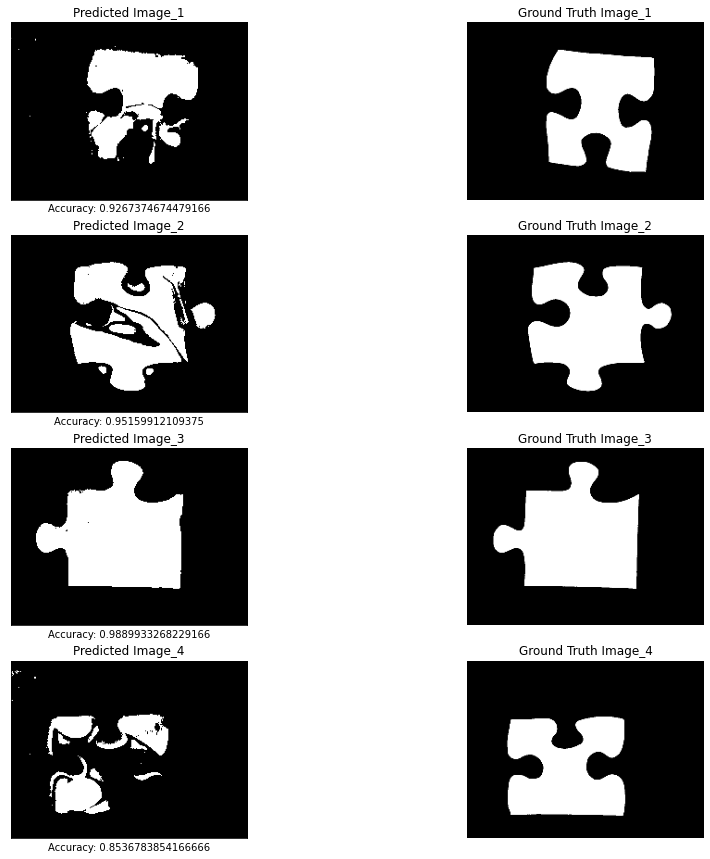

Average Training Time:  13.005040089289347
Average Total Accuracy after 3 runs: 0.9353434244791666


In [ ]:
features = get_features_rgbdoG(training_imgs, 49, 29)
background, foreground = split_features(training_msks, features)

total_features_test = get_features_rgbdoG(validation_imgs, 49, 29)
best_pred = np.array([])
accuracy = 0
max_acc = 0
n_runs = 3
start = time()
for i in range(n_runs):
  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 2, side="background", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 2, side="foreground", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 2, prior = 0.4, shape = validation_msks.shape)
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), validation_msks.flatten().astype(np.uint8))
  
  acc = (conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  accuracy += acc
  if acc > max_acc:
    best_pred = pred_msks
    max_acc = acc

end = time()
plot_predictions(validation_msks, best_pred)
print("Average Training Time: ", (end - start)/n_runs)
# print("Number of iterations for background GMM: ", n_iters_bg)
# print("Number of iterations for foreground GMM: ", n_iters_fg)
print('Average Total Accuracy after ' + str(n_runs)+ ' runs:',accuracy/n_runs)

6-fold validation for Gaussian Difference of 20

In [ ]:
# split imgs into 6 equal arrays (folds)
six_foldImgs=(np.array(np.split(imgs,6)))
six_foldMsk=(np.array(np.split(msks,6)))

# initialise accuracy
accuracy=0
start = time()
# loop through folds
# each fold has the opportunity to be a test set with the remaining folds representing the 
# training sets
for fold in range(six_foldImgs.shape[0]):
  print('Fold: ',str(fold))

  # compile the testing set= 1 fold
  testing_features=six_foldImgs[fold]
  testing_msks=six_foldMsk[fold]
  training_features=[]
  training_masks=[]

  # compile the training set which is equal to 5 folds
  for k in range(six_foldImgs.shape[0]):
    if (k!=fold):
      training_features.append(six_foldImgs[k])
      training_masks.append(six_foldMsk[k])
  training_features=np.array(training_features)
  training_masks=np.array(training_masks)
  
  training_features=training_features.reshape(40,training_features.shape[2], training_features.shape[3],3)
  training_masks=training_masks.reshape(40,training_masks.shape[2], training_masks.shape[3])



    ##########################  DEFINE FEATURES FOR TRAINING ###################################
  total_features = get_features_rgbdoG(training_features,49,29)
  background, foreground = split_features(training_masks, total_features)

  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 2, side="background", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 2, side="foreground", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)


  ################### GET FEATURES FOR TESTING ##########################################
  total_features_test = get_features_rgbdoG(testing_features,49,29)

  ########################## GET PREDICTED MASKS ###########################################
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 2, prior = 0.4, shape = testing_msks.shape)

  # generate confusion matrix to determine accuracy
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), testing_msks.flatten().astype(np.uint8))
  new_accuracy=(conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  print('Accuracy for fold',str(fold),":",new_accuracy)

  accuracy+=new_accuracy

end = time()
print("Total Training Time: ", (end - start))
# accuracy is mean of all the runs per fold as test set i.e. mean of 6 runs
print('Final accuracy',accuracy/6)

Fold:  0
Accuracy for fold 0 : 0.9209950764973959
Fold:  1
Accuracy for fold 1 : 0.9467137654622396
Fold:  2
Accuracy for fold 2 : 0.9578475952148438
Fold:  3
Accuracy for fold 3 : 0.9121271769205729
Fold:  4
Accuracy for fold 4 : 0.9600245157877604
Fold:  5
Accuracy for fold 5 : 0.9432500203450521
Total Training Time:  55.50777006149292
Final accuracy 0.9401596917046441


GAUSSIAN DIFFERENCE OF 30

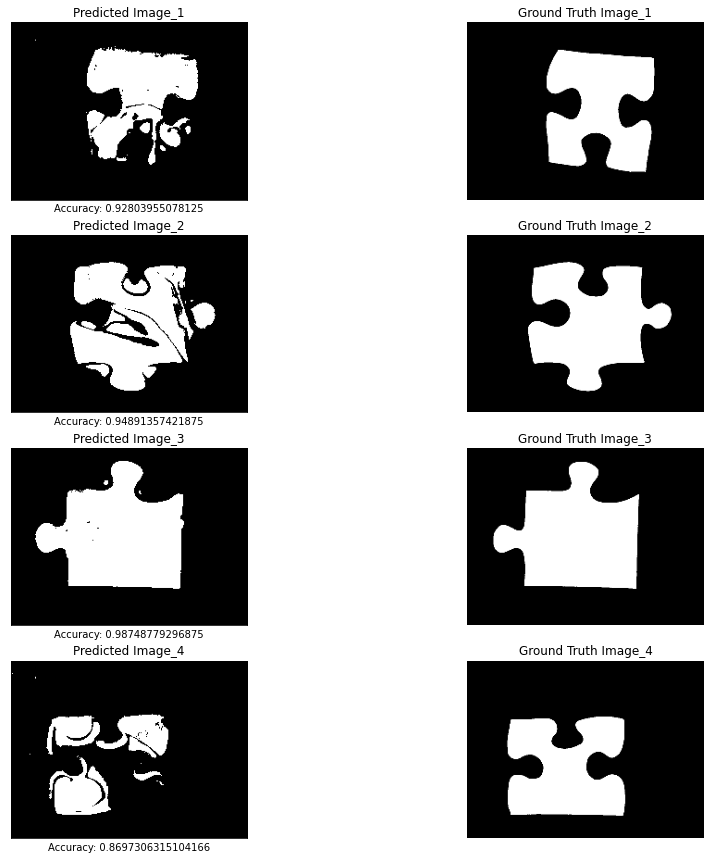

Average Training Time:  13.114469607671102
Average Total Accuracy after 3 runs: 0.9380464099702381


In [ ]:
features = get_features_rgbdoG(training_imgs, 49, 19)
background, foreground = split_features(training_msks, features)

total_features_test = get_features_rgbdoG(validation_imgs, 49, 19)
best_pred = np.array([])
accuracy = 0
max_acc = 0
n_runs = 3
start = time()
for i in range(n_runs):
  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 2, side="background", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 2, side="foreground", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 2, prior = 0.4, shape = validation_msks.shape)
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), validation_msks.flatten().astype(np.uint8))
  
  acc = (conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  accuracy += acc
  if acc > max_acc:
    best_pred = pred_msks
    max_acc = acc

end = time()
plot_predictions(validation_msks, best_pred)
print("Average Training Time: ", (end - start)/n_runs)
# print("Number of iterations for background GMM: ", n_iters_bg)
# print("Number of iterations for foreground GMM: ", n_iters_fg)
print('Average Total Accuracy after ' + str(n_runs)+ ' runs:',accuracy/n_runs)

6-fold validation for Gaussian Difference of 30

In [ ]:
# split imgs into 6 equal arrays (folds)
six_foldImgs=(np.array(np.split(imgs,6)))
six_foldMsk=(np.array(np.split(msks,6)))

# initialise accuracy
accuracy=0
start = time()
# loop through folds
# each fold has the opportunity to be a test set with the remaining folds representing the 
# training sets
for fold in range(six_foldImgs.shape[0]):
  print('Fold: ',str(fold))

  # compile the testing set= 1 fold
  testing_features=six_foldImgs[fold]
  testing_msks=six_foldMsk[fold]
  training_features=[]
  training_masks=[]

  # compile the training set which is equal to 5 folds
  for k in range(six_foldImgs.shape[0]):
    if (k!=fold):
      training_features.append(six_foldImgs[k])
      training_masks.append(six_foldMsk[k])
  training_features=np.array(training_features)
  training_masks=np.array(training_masks)
  
  training_features=training_features.reshape(40,training_features.shape[2], training_features.shape[3],3)
  training_masks=training_masks.reshape(40,training_masks.shape[2], training_masks.shape[3])



    ##########################  DEFINE FEATURES FOR TRAINING ###################################
  total_features = get_features_rgbdoG(training_features,49, 19)
  background, foreground = split_features(training_masks, total_features)

  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 2, side="background", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 2, side="foreground", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)


  ################### GET FEATURES FOR TESTING ##########################################
  total_features_test = get_features_rgbdoG(testing_features,49, 19)

  ########################## GET PREDICTED MASKS ###########################################
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 2, prior = 0.4, shape = testing_msks.shape)

  # generate confusion matrix to determine accuracy
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), testing_msks.flatten().astype(np.uint8))
  new_accuracy=(conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  print('Accuracy for fold',str(fold),":",new_accuracy)

  accuracy+=new_accuracy

end = time()
print("Total Training Time: ", (end - start))
# accuracy is mean of all the runs per fold as test set i.e. mean of 6 runs
print('Final accuracy',accuracy/6)

Fold:  0
Accuracy for fold 0 : 0.9205780029296875
Fold:  1
Accuracy for fold 1 : 0.9416707356770834
Fold:  2
Accuracy for fold 2 : 0.9545669555664062
Fold:  3
Accuracy for fold 3 : 0.9132232666015625
Fold:  4
Accuracy for fold 4 : 0.9567743937174479
Fold:  5
Accuracy for fold 5 : 0.9449412027994791
Total Training Time:  41.94204306602478
Final accuracy 0.9386257595486112


WE OBSERVE THAT THE PREDICTION ACCURACY INCREASES WITH A BIGGER GAUSSIAN DIFFERENCE (DIFFERENCE IN BLURRINESS BETWEEN TWO BLURRED VERSIONS OF AN IMAGE)

#All Features: rgb, rgb+doG , hsv Combination

Using 2 Clusters on RGB, HSV, DoG combination

Average Training Time:  42.511840184529625


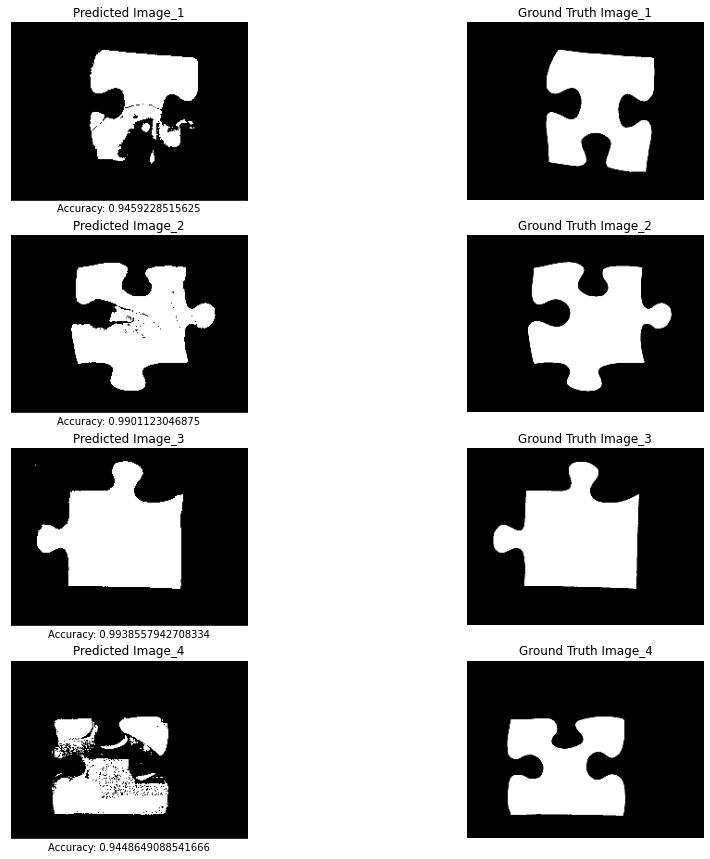

Average Total Accuracy after 3 runs: 0.9680069211929564


In [ ]:
features = get_features(training_imgs, 49, 19)


background, foreground = split_features(training_msks, features)

total_features_test = get_features(validation_imgs, 49, 19)
best_pred = np.array([])
accuracy = 0
max_acc = 0
n_runs = 3
start = time()
for i in range(n_runs):
  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 2, side="background", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 2, side="foreground", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 2, prior = 0.4, shape = validation_msks.shape)
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), validation_msks.flatten().astype(np.uint8))
  
  acc = (conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  accuracy += acc
  if acc > max_acc:
    best_pred = pred_msks
    max_acc = acc

end = time()
print("Average Training Time: ", (end - start)/n_runs)
plot_predictions(validation_msks, best_pred)
print('Average Total Accuracy after ' + str(n_runs)+ ' runs:',accuracy/n_runs)

Performing 6-fold validation on RGB, HSV, DoG combination (2 Clusters)

In [ ]:
# split imgs into 6 equal arrays (folds)
six_foldImgs=(np.array(np.split(imgs,6)))
six_foldMsk=(np.array(np.split(msks,6)))

# initialise accuracy
accuracy=0
start = time()
# loop through folds
# each fold has the opportunity to be a test set with the remaining folds representing the 
# training sets
for fold in range(six_foldImgs.shape[0]):
  print('Fold: ',str(fold))

  # compile the testing set= 1 fold
  testing_features=six_foldImgs[fold]
  testing_msks=six_foldMsk[fold]
  training_features=[]
  training_masks=[]

  # compile the training set which is equal to 5 folds
  for k in range(six_foldImgs.shape[0]):
    if (k!=fold):
      training_features.append(six_foldImgs[k])
      training_masks.append(six_foldMsk[k])
  training_features=np.array(training_features)
  training_masks=np.array(training_masks)
  
  training_features=training_features.reshape(40,training_features.shape[2], training_features.shape[3],3)
  training_masks=training_masks.reshape(40,training_masks.shape[2], training_masks.shape[3])



    ##########################  DEFINE FEATURES FOR TRAINING ###################################
  total_features = get_features(training_features,11,9)
  background, foreground = split_features(training_masks, total_features)

  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 2, side="background", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 2, side="foreground", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)


  ################### GET FEATURES FOR TESTING ##########################################
  total_features_test = get_features(testing_features,11,9)

  ########################## GET PREDICTED MASKS ###########################################
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 2, prior = 0.4, shape = testing_msks.shape)

  # generate confusion matrix to determine accuracy
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), testing_msks.flatten().astype(np.uint8))
  new_accuracy=(conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  print('Accuracy for fold',str(fold),":",new_accuracy)

  accuracy+=new_accuracy

end = time()
print("Total Training Time: ", (end - start))
# accuracy is mean of all the runs per fold as test set i.e. mean of 6 runs
print('Final accuracy',accuracy/6)

Fold:  0
Accuracy for fold 0 : 0.9503300984700521
Fold:  1
Accuracy for fold 1 : 0.9675496419270834
Fold:  2
Accuracy for fold 2 : 0.9807103474934896
Fold:  3
Accuracy for fold 3 : 0.9356002807617188
Fold:  4
Accuracy for fold 4 : 0.9834416707356771
Fold:  5
Accuracy for fold 5 : 0.9604339599609375
Total Training Time:  303.85252571105957
Final accuracy 0.963010999891493


3 clusters on RGB, HSV, DoG combination 


Total Training Time:  66.35566973686218


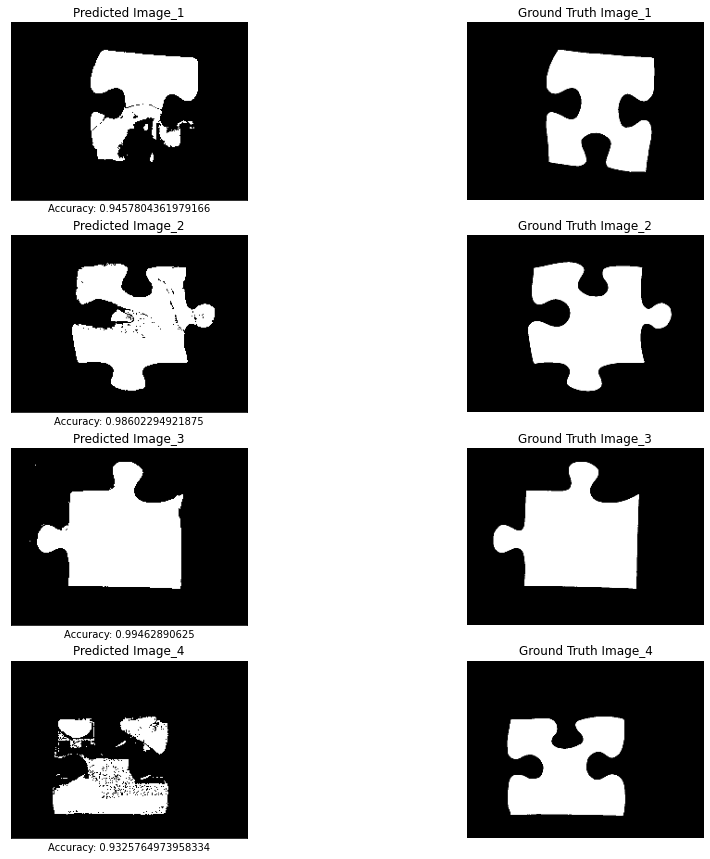

Average Total Accuracy after 3 runs: 0.9227556501116071


In [ ]:
features = get_features(training_imgs, 49, 19)
background, foreground = split_features(training_msks, features)

total_features_test = get_features(validation_imgs, 49, 19)
best_pred = np.array([])
accuracy = 0
max_acc = 0
n_runs = 3

start = time()
for i in range(n_runs):
  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 3, side="background", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 3, side="foreground", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 3, prior = 0.4, shape = validation_msks.shape)
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), validation_msks.flatten().astype(np.uint8))
  
  acc = (conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  accuracy += acc
  if acc > max_acc:
    best_pred = pred_msks
    max_acc = acc


end = time()
print("Total Training Time: ", (end - start)/3)
plot_predictions(validation_msks, best_pred)
print('Average Total Accuracy after ' + str(n_runs)+ ' runs:',accuracy/n_runs)

6-fold validation on RGB, HSV, DoG combination (3 Clusters)

In [ ]:
# split imgs into 6 equal arrays (folds)
six_foldImgs=(np.array(np.split(imgs,6)))
six_foldMsk=(np.array(np.split(msks,6)))

# initialise accuracy
accuracy=0

# capture time taken to run
start=time()

# loop through folds
# each fold has the opportunity to be a test set with the remaining folds representing the 
# training sets
for fold in range(six_foldImgs.shape[0]):
  print('Fold: ',str(fold))

  # compile the testing set= 1 fold
  testing_features=six_foldImgs[fold]
  testing_msks=six_foldMsk[fold]
  training_features=[]
  training_masks=[]

  # compile the training set which is equal to 5 folds
  for k in range(six_foldImgs.shape[0]):
    if (k!=fold):
      training_features.append(six_foldImgs[k])
      training_masks.append(six_foldMsk[k])
  training_features=np.array(training_features)
  training_masks=np.array(training_masks)
  
  training_features=training_features.reshape(40,training_features.shape[2], training_features.shape[3],3)
  training_masks=training_masks.reshape(40,training_masks.shape[2], training_masks.shape[3])



    ##########################  DEFINE FEATURES FOR TRAINING ###################################
  total_features = get_features(training_features,11,9)
  background, foreground = split_features(training_masks, total_features)

  delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 3, side="background", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)
  delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 3, side="foreground", epsilon = 0.1, max_iters=30, min_iters = 10, foreground=foreground, background=background)


  ################### GET FEATURES FOR TESTING ##########################################
  total_features_test = get_features(testing_features,11,9)

  ########################## GET PREDICTED MASKS ###########################################
  pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 3, prior = 0.4, shape = testing_msks.shape)

  # generate confusion matrix to determine accuracy
  conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), testing_msks.flatten().astype(np.uint8))
  new_accuracy=(conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)
  print('Accuracy for fold',str(fold),":",new_accuracy)

  accuracy+=new_accuracy


end = time()
print("Total Training Time: ", (end - start))

# accuracy is mean of all the runs per fold as test set i.e. mean of 6 runs
print('Final accuracy',accuracy/6)

Fold:  0
Accuracy for fold 0 : 0.8930791219075521
Fold:  1
Accuracy for fold 1 : 0.7241795857747396
Fold:  2
Accuracy for fold 2 : 0.8985188802083334
Fold:  3
Accuracy for fold 3 : 0.9063542683919271
Fold:  4
Accuracy for fold 4 : 0.9831695556640625
Fold:  5
Accuracy for fold 5 : 0.9015630086263021
Total Training Time:  495.17471575737
Final accuracy 0.8844774034288195


#HSV and RGB_(rgb+doG)\_hsv combination generally results in the hihest accuracies. However we could say that HSV is the optimal feature set to use since it is smaller than RGB_(rgb+doG)_hsv combination. 

#Using 2 clusters consistently results in a higher accuracy than 3 clusters

SILHOUETTE SCORE

  Please note that the code below takes extremely long to run due to the number of datapoints that need to be checked for their distances. It is not recommended that this code is run unless you have a lot of hours to spare. It works, however, and calculates the silhouette score correctly.

  Silhouette scores are used to determine the optimal number of clusters.

In [ ]:
from sklearn import metrics # for calculating Silhouette score


# Create empty list
S=[]

# Range of clusters to try (2 to 10)
K=range(2,6)

# Select data for clustering model
features = get_features(testing_imgs, 11, 9)
total_features_test = get_features(validation_imgs, 11, 9)
background, foreground = split_features(validation_msks, total_features_test)

for k in K:
    # Set the model and its parameters
    delta_back, mean_back, cov_back = GMM(n_clusters = k, side="background", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
    delta_fore, mean_fore, cov_fore = GMM(n_clusters = k, side="foreground", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
    pred_msks = get_predicted_masks(features, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = k, prior = 0.4, shape = validation_msks.shape)
    # Calculate Silhoutte Score and append to a list
    S.append(metrics.silhouette_score(features, testing_msks.flatten(), metric='euclidean'))

# Plot the resulting Silhouette scores on a graph
plt.figure(figsize=(16,8), dpi=300)
plt.plot(K, S, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Identify the number of clusters using Silhouette Score')
plt.show()

#We will use now use HSV and 2 clusters to do final testing

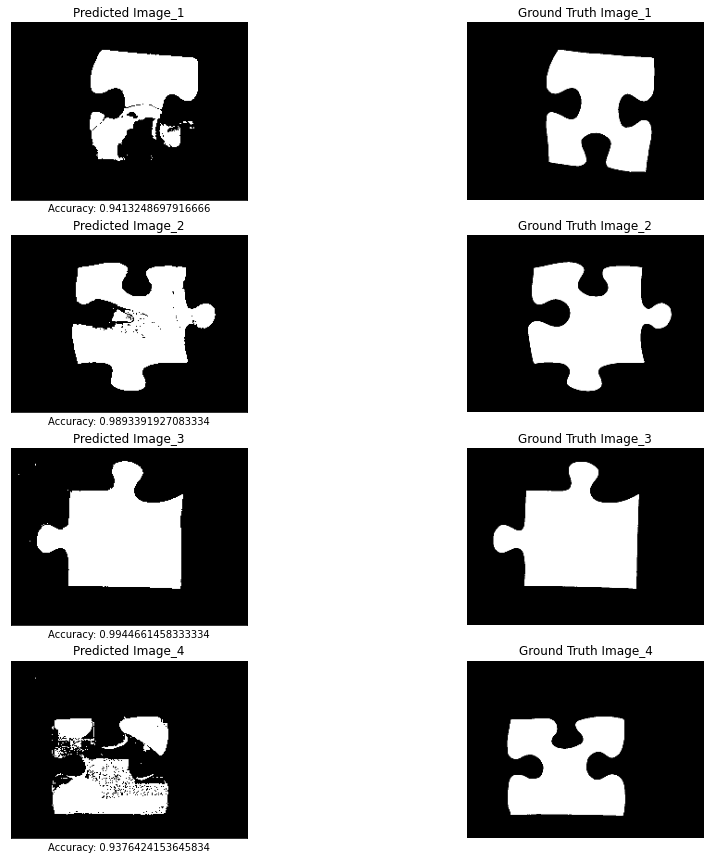

Total accuracy:  0.9666399274553571


In [ ]:
features = get_features_hsv(training_imgs)
background, foreground = split_features(training_msks, features)

total_features_test = get_features_hsv(validation_imgs)
best_pred = np.array([])
accuracy = 0
max_acc = 0
n_runs = 3
start = time()
delta_back, mean_back, cov_back, n_iters_bg = GMM(n_clusters = 2, side="background", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
delta_fore, mean_fore, cov_fore, n_iters_fg = GMM(n_clusters = 2, side="foreground", epsilon = 0.1, max_iters = 30, min_iters = 10, foreground=foreground, background=background)
  

pred_msks = get_predicted_masks(total_features_test, delta_back, mean_back, cov_back , delta_fore, mean_fore, cov_fore, n_clusters = 2, prior = 0.4, shape = validation_msks.shape)
conf_matrix=confusion_matrix(pred_msks.flatten().astype(np.uint8), validation_msks.flatten().astype(np.uint8))
accuracy = (conf_matrix[0][0]+conf_matrix[1][1])/ np.sum(conf_matrix)

plot_predictions(validation_msks, pred_msks)
print("Total accuracy: ", accuracy)